# Wstęp
## Cel ćwiczenia
Na tych zajęciach napiszesz od zera prosty klasyfikator liniowy - **Perceptron**. Rzadko kiedy programując **sieci neuronowe** musimy się posuwać do implementowania czegoś od zera. Jednak tym razem to zrobimy, żeby lepiej zrozumieć i opanować idee **propagacji w przód** (ang. *forward propagation*) i **propagacji wstecznej** (ang. *backward propagation*), a także zmierzyć się z problemami na jakie natrafiamy programując sieci neronowe (np. problemy ze **stabilnością numeryczną**), czy też dowiedzieć się w jaki sposób bronić się przed **przeuczeniem** (ang. *overfitting*) modelu.
## Warunki zaliczenia
W celu zaliczenia ćwiczeń należy uzupełnić wszystkie brakujące elementu kodu, wykonać wszystkie polecenia i wyuczyć model.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import sklearn.datasets
import torch

from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

assert torch.cuda.is_available(), "Uruchom środowisko wykonawcze na GPU"

# Problem

Na tych zajęciach będziemy pracować na jednym z najbardziej znanych i oklepanych zbiorów danych, które są wykorzystywane do prezentacji technik z uczenia maszynowego - Irysy: [Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set), [scikit-learn](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

Jest to zbiór danych zawierający informację o długości i szerokości płatków i działek kielicha dla 3 gatunków irysów:

*   Iris Setosa (0)
*   Iris Versicolour (1)
*   Iris Virginica (2)

Naszym zadaniem jest stworzenie klasyfikatora, który dla podanych cech $(x_0, x_1, x_2, x_3)$ przypisze klasę $\{0, 1, 2\}$, tj. fukncji $f: \mathbb{R}^4 \to \{0, 1, 2\}$.

Załadujmy zbiór danych.

In [ ]:
X, y = sklearn.datasets.load_iris(return_X_y=True)
X[:2], y[:2]

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2]]),
 array([0, 0]))

# Liniowa separowalność problemu

Na początek omówmy koncepcję istotną z punktu widzenia głębokich sieci neuronowych - separowalność liniową. Skupmy się na razie na dwóch cechach irysów: długości i szerokości działek kielichów. Zobaczmy jak te chechy rozkładają się na wykresie.

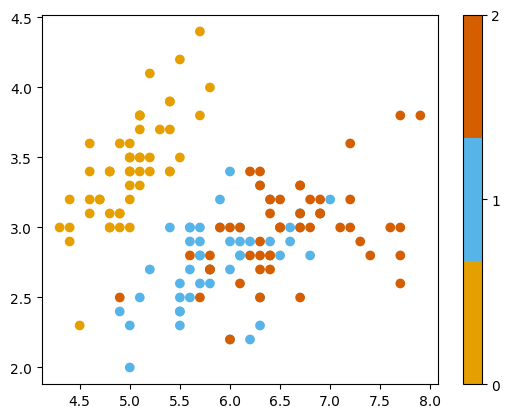

In [ ]:
scat = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(["#E69F00", "#56B4E9", "#D55E00"]))
plt.colorbar(scat, spacing='proportional',ticks=np.linspace(0,3,4))

Patrząc na powyższy wykres ***wyznacz*** granicę decyzyjną pomiędzy *Iris Setosa* (0) a dwoma pozostałymi irysami. Wyznaczona granica decyzyjna powinna być taka, że powyżej jej są tylko *Iris Setosa* (0) a poniżej - pozostałe dwa gatunki.

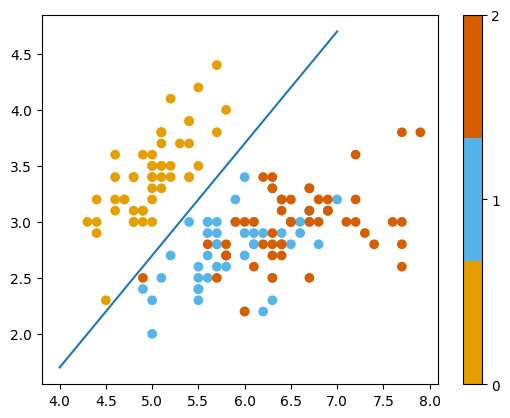

In [ ]:
scat = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(["#E69F00", "#56B4E9", "#D55E00"]))
plt.colorbar(scat, spacing='proportional',ticks=np.linspace(0,3,4))

x = np.arange(4, 8)
m = 1
b = 2.3
plt.plot(x, m*x - b)

Zauważ, że poprawnych granic decyzyjnych jest nieskończenie wiele. Zobacz także, że nie bylibyśmy wstanie rodzielić między sobą dwa pozostałe gatunki: *Iris Versicolour* (1) oraz *Iris Virginica* (2).

Jak widać przedstawiony problem (*Iris Setosa* czy nie-*Iris Setosa*) jest liniowo separowalny - istnieje linia, która rozdziela te dwie klasy ze względu na długość i szerokość działki kielicha. Uogólniając, problem jest liniowo seperowalny wtedy i tylko wtedy, gdy w $n$ wymiarowej przestrzeni jesteśmy wstanie wyznaczyć $n-1$ wymiarową płaszczyznę rozdzielającą klasy. W tym przypadku mieliśmy $2$-wymiarową przestrzeń, w której trzeba było wyznaczyć $1$-wymiarową linię.

# Przeuczenie - podział na zbiór uczący, walidacyjny i testowy
Jednym z podstawowych probemów z jakimi trzeba się zmierzyć przy uczeniu klasyfikatorów jest przeuczenie, tj. sytuacja w której klasyfikator bardzo dobrze nauczy się rozpoznawać próbki, które dostał w procesie uczenia, ale już gorzej będzie rozponawał nowe dane.

Żeby uchronić się przed taką sytuacją często dokonujemy podziału zbioru danych na zbiory: **uczący, walidacyjny i testowy** (ang. *train, validation, test*). Zbiór uczący służy do wyznaczenia **parametrów** modelu, walidaycyjny - do strojenia **hiperparametrów** modelu (np. liczba iteracji uczenia), a testowy - do ostatecznego przetestowania jakości naszego modelu. Czasami ograniczamy się tylko do zbioru uczącego i testowego, jak planujemy tylko uczyć parametry modelu.

***Podziel*** zbiór z irysami na dwa zbiory - uczący i testowy. Umieść 20% próbek w zbiorze testowym a 80% w uczącym. Dokonaj ***stratyfikacji*** danych. Użyj fukncji `sklearn.model_selection.train_test_split`. Ustaw parametr `random_state` na $1$, żeby mieć jeden ustalony podział. Zapoznaj się z [dokumentacją](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train%20test#sklearn.model_selection.train_test_split) przed przystąpieniem do zadania.

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

X_train = torch.tensor(X_train, dtype=torch.float).cuda()
X_test = torch.tensor(X_test, dtype=torch.float).cuda()

# Jeden-vs-reszta

Jak zaraz zobaczymy, perceptron z sigmoidem zwraca wartości z przedziału $[0,1]$, które to nazywamy **pseudoprawdopodobieństwami**. Na przykład, jeżeli klasyfikator zwraca wartość $0.7$ dla danej próbki, to oznacza to, że na 70% jest to klasa 1, a na 30% klasa 0.

A więc trzymając się tej konwencji, jak tutaj "zmieścić" 3 klasy (0, 1, 2)? Jednym z podejść jest jeden-vs-reszta (ang. *one-vs-rest*, *OVR*). Przyjmujemy, że jedna z klas zostaje jedynką a resztę oznaczamy jako 0. Na przykład klasę 2 przemianowujemy na 1, a 0 i 1 na 0. Zresztą to co zrobiliśmy w rozdziale *Liniowa separowalność problemu* to jest dokładnie to - skupiliśmy się na klasyfikacji czy dana roślina to jeden określony gatunek irysów czy może których z dwóch pozostałych. I tak też będziemy robić w dalszej części laboratorium.

***Uzupełnij*** i uruchom poniższy kod.

In [ ]:
def get_ovr_labels(y_train, y_test):
    y_train_ovr = {}
    y_test_ovr = {}
    for clas in range(3):
        y_train_ovr[clas] = torch.tensor([1 if x == clas else 0 for x in y_train]).cuda()
        y_test_ovr[clas] = torch.tensor([1 if x == clas else 0 for x in y_test]).cuda()

    return y_train_ovr, y_test_ovr

y_train_ovr, y_test_ovr = get_ovr_labels(y_train, y_test)

Sprawdź czy dobrze zaimplementowałaś(eś) funkcję.

In [ ]:
print(y_test)
for clas in range(3):
    print(y_test_ovr[clas])

[2 0 1 0 0 0 2 2 2 1 0 1 2 1 2 0 2 1 1 2 1 1 0 0 2 2 0 0 1 1]
tensor([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 0], device='cuda:0')
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0], device='cuda:0')


# Perceptron

Twoim zadaniem będzie napisanie Perceptrona - podstawowej "komórki" sieci neuronowej.

## Sigmoid

Spójrz na poniższy kod implementujący funkcję sigmoid ze wzoru $\sigma(x) = \frac{1}{1 + e^{-x}}$ dla $x \geq 0$ oraz $\sigma(x) = \frac{e^x}{e^x + 1}$ dla $x < 0$.

In [ ]:
def sigmoid_scalar(x):
    if x >= 0:
      return 1 / (1 + torch.exp(-x))
    return torch.exp(x) / (torch.exp(x) + 1)

def sigmoid_tensor(t):
    return torch.tensor([sigmoid_scalar(x) for x in t])

sigmoid_test_tensor = torch.tensor([-100.0, 100.0, -1000.0, 1000.0, 0.0, 1.0, -1.0, 100000000.0, -100000000.0]).cuda()
sigmoid_tensor(sigmoid_test_tensor).cuda()

tensor([3.7835e-44, 1.0000e+00, 0.0000e+00, 1.0000e+00, 5.0000e-01, 7.3106e-01,
        2.6894e-01, 1.0000e+00, 0.0000e+00], device='cuda:0')

Jeżeli nie widzisz dla czego trzeba rodzielić liczenie sigmoidu na dwa przypadki to spróbuj policzyć $\sigma(-100)$ i $\sigma(100)$ korzystając z obu wzorów. Czym się różnią wyniki? Dlaczego?

In [ ]:
print(1 / (1 + torch.exp(-sigmoid_test_tensor[0])))
print(torch.exp(sigmoid_test_tensor[1]) / (torch.exp(sigmoid_test_tensor[1]) + 1))

tensor(0., device='cuda:0')
tensor(nan, device='cuda:0')


Niestety, ale problemy ze **stablinością numeryczną** w sieciach neuronowych są dość powszechne. Na dziś wystarczy tylko, że zapamiętasz, że pośrednie wyniki obliczeń mogą być za małe albo za duże, żeby zapisać je do zmiennoprzecinkowej postaci (ang. *floating-point format*).

Ta funkcja ma jeszcze jeden problem. Obecnie **iterujmey w pętli** po elementach tensora zamiast wykonywać operacje matematyczne (dodawanie, mnożenie etc.) na tensorach, co jest znacznie wolniejsze i mniej eleganckie.

Jeżeli chcemy **efektywnie** używać sigmoida do uczenia musimy zmienić naszą implementację. Dlatego też skorzystamy z innego wzoru $\sigma(x) = \exp(-\ln(\exp(0) + \exp(-x)))$. Ten wzór ma jedną podstawową zaletę - możemy skorzystać z numercznie stabilnego [`torch.logaddexp`](https://pytorch.org/docs/stable/generated/torch.logaddexp.html).

***Zaimplementuj*** funkcję sigmoid używając wzoru $\sigma(x) = \exp(-\ln(\exp(0) + \exp(-x)))$ oraz funkcji [`torch.logaddexp`](https://pytorch.org/docs/stable/generated/torch.logaddexp.html).

In [ ]:

def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return torch.exp(-torch.logaddexp(torch.tensor(0, device=x.device), -x))

s = sigmoid(sigmoid_test_tensor).cuda()

print(s)
print(type(s))
assert isinstance(s, torch.cuda.FloatTensor)

tensor([3.7835e-44, 1.0000e+00, 0.0000e+00, 1.0000e+00, 5.0000e-01, 7.3106e-01,
        2.6894e-01, 1.0000e+00, 0.0000e+00], device='cuda:0')
<class 'torch.Tensor'>


Dla pewności jeszcze sprawdzimy czy na pewno implementacja z użyciem operacji na tensorach jest szybsza.

In [ ]:
print("*** Rozwiązanie iteracyjne ***")
%timeit sigmoid_tensor(torch.rand(10000).cuda())
print()
print("*** Rozwiązanie z użyciem operacji na tensorach ***")
%timeit sigmoid(torch.rand(10000).cuda())

*** Rozwiązanie iteracyjne ***
926 ms ± 41.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

*** Rozwiązanie z użyciem operacji na tensorach ***
178 µs ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Nawet przy implementacji tak prostej funkcji mieliśmy dwa wyzwania, którym trzeba było sprostać: (1) zapewnić **stabilność numerczyną** operacji oraz (2) zapewnić, że będziemy wykonywać **efektywne operacje na wektorach**. Są to dwie istotne kwestie, o których należy pamiętać projektując sieci neuronowe.

## Inicjalizacja parametów

***Napisz*** funkcję, która zwróci krotkę dwuelementową - pierwszym elementem będzie tensor zawierający **parametry** modelu - na razie same zera - oraz parametr b (ang. *bias*) - też równy zero.

In [ ]:
from typing import Tuple

def initialize_with_zeros(length: int) -> Tuple[torch.Tensor, torch.Tensor]:
    w = torch.zeros(length, dtype=torch.float, device="cuda")
    b = torch.zeros(1, dtype=torch.float, device="cuda")
    return w, b

***Przetestuj*** swoją implementację. Kod poniżej powinien wykonać się bez błędów i wyjątków

In [ ]:
w, b = initialize_with_zeros(42)


assert isinstance(w, torch.cuda.FloatTensor)
assert isinstance(b, torch.cuda.FloatTensor)
assert w.shape == (42,)
assert not [x for x in w if x != 0]
assert b.shape == (1,)
assert b == 0

## Propagacja wsteczna i propagacja w przód

Niech $m$ będzie liczbą próbek, na których uczymy model.

***Zaimplementuj*** funkcję `activation_fn`. Policz funkcję aktywacji ze wzroru $A = \sigma(Xw + b) = (a_0, a_1, \ldots, a_{m-1})$.

***Nie korzystaj*** z pętli, tylko z operacji na wektorach/macierzach.

In [ ]:
def activation_fn(w: torch.Tensor, b: torch.Tensor, X: torch.Tensor) -> torch.Tensor:
    return sigmoid(torch.matmul(X, w) + b)



```
# This is formatted as code
```

***Przetestuj kod***. W tym celu ***zamień*** `___` na taką liczbę, żeby kod zadziałał poprawnie. Zastanów się dlaczego akurat taka liczba parametrów jest potrzebna a nie inna?

In [ ]:
# Taka sama liczba jak liczba cech w zbiorze X_train
w, b = initialize_with_zeros(4)
y_pred_prob = activation_fn(w, b, X_train[:10])
print(y_pred_prob)

assert isinstance(y_pred_prob, torch.cuda.FloatTensor)
assert y_pred_prob.shape == (10,)
assert not [x for x in y_pred_prob if x != 0.5]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000], device='cuda:0')


Powinieneś/powinnaś dostać:

```
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000], device='cuda:0')
```

Zauważ, że to oznacza, że dla każdej z 10 próbek model przyporządkował pseudoprawdopodobieństwo równe $0.5$. Jest to zrozumiałe, ponieważ model na razie nie posiada żadnej wiedzy, dlatego też przypisuje takie samo prawdopodbieństwo klasie 1 i 0 dla każdej próbki.

***Zaimplementuj*** funkcję `forward` dokonującą propagacji w przód. Wylicz wartość funkcji aktywacji korzystając z wcześniej zaimlepementowanej funkcji `activation_fn`. Funkcję kosztu policz ze wzoru $loss = - \frac{1}{m} \sum^{m-1}_{i=0} y_i\log(a_i) + (1 - y_i)log(1 - a_i)$.

***Zaimplementuj*** funkcję `backward` dokonującą propagacji wstecznej. Policz gradient dla wektora $w$ ze wzoru $ \frac{\partial loss}{\partial w} = \frac{1}{m}EX$ (gdzie $E$ to błąd, $E=A-Y$), a gradient dla $b$ ze wzoru $ \frac{\partial loss}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a_i-y_i)$.

***Nie korzystaj*** z pętli, tylko z operacji na wektorach/macierzach.

In [74]:
def propagate(w: torch.Tensor, b: torch.Tensor, X: torch.Tensor, y: torch.Tensor):
    m = torch.tensor([X.shape[0]]).cuda()

    def forward():
        A = activation_fn(w, b, X)
        loss = -torch.sum(y * torch.log(A) + (1 - y) * torch.log(1 - A)) / m
        return A, loss

    def backward(A):
        error = A - y
        dw = torch.matmul(error, X) / m
        db = torch.sum(error) / m
        return dw, db

    A, loss = forward()
    dw, db = backward(A)

    return dw, db, loss

***Przetestuj kod***. W tym celu ***zamień*** `___` na taką liczbę, żeby kod zadziałał poprawnie.

In [75]:
w, b = initialize_with_zeros(4)
dw, db, loss = propagate(w, b, X_train[:10], y_train_ovr[1][:10])
print(dw, db, loss)

assert isinstance(dw, torch.cuda.FloatTensor)
assert isinstance(db, torch.cuda.FloatTensor)
assert isinstance(loss, torch.cuda.FloatTensor)
assert torch.allclose(dw, torch.tensor([-0.0700,  0.0650, -0.1600, -0.0050]).cuda(), atol=1e-04, rtol=0)
assert torch.allclose(b, torch.tensor([0.0]).cuda(), atol=1e-04, rtol=0)
assert torch.allclose(loss, torch.tensor([0.6931]).cuda(), atol=1e-04, rtol=0)

tensor([-0.0700,  0.0650, -0.1600, -0.0050], device='cuda:0') tensor([0.], device='cuda:0') tensor([0.6931], device='cuda:0')



Powinnaś(eś) dostać:

```
tensor([-0.0700,  0.0650, -0.1600, -0.0050], device='cuda:0',
       dtype=torch.float64) tensor([0.], device='cuda:0', dtype=torch.float64) tensor([0.6931], device='cuda:0', dtype=torch.float64)
```



## Uczenie

***Zaprogramuj*** iteracyjny proces uczenia modelu, tzn. powtarzaj proces propagacji w przód i propagacji wstecznej `num_iterations` razy. Podczas aktulizacji parametrów $w$ i $b$ ***uwzględnij*** `learning_rate` tj. współczynnik uczenia, który mówi nam o tym jak "szybko" chcemy podąrzać za zwrotem gradientu. Zauważ, że `num_iterations` i `learning_rate` to hiperparametry modelu, a $w$ i $b$ to jego parametry.

In [80]:
def train(w, b, X, Y, num_iterations, learning_rate, print_loss=False):
    losses = []

    for i in range(num_iterations):
        dw, db, loss = propagate(w, b, X, Y)
        w -= learning_rate * dw
        b -= learning_rate * db

        losses.append(loss)
        if print_loss:
            print(f"Loss after iteration {i}: {loss}")

    return w, b, losses


***Przetestuj*** działanie napisanego przez siebie kodu

In [81]:
w, b = initialize_with_zeros(4)
w, b, losses = train(w, b, X_train[:10], y_train_ovr[1][:10], 5, 0.005)
print(w, b, losses)

assert isinstance(w, torch.cuda.FloatTensor)
assert isinstance(b, torch.cuda.FloatTensor)
assert torch.allclose(w, torch.tensor([1.4422e-03, -1.7717e-03, 3.7738e-03, 4.6234e-05]).cuda(), atol=1e-04, rtol=0)
assert torch.allclose(b, torch.tensor([-5.0243e-05]).cuda(), atol=1e-04, rtol=0)
assert torch.allclose(torch.tensor(losses), torch.tensor([0.6931, 0.6930, 0.6928, 0.6927, 0.6925]), atol=1e-04, rtol=0)

tensor([ 1.4422e-03, -1.7717e-03,  3.7738e-03,  4.6234e-05], device='cuda:0') tensor([-5.0243e-05], device='cuda:0') [tensor([0.6931], device='cuda:0'), tensor([0.6930], device='cuda:0'), tensor([0.6928], device='cuda:0'), tensor([0.6927], device='cuda:0'), tensor([0.6925], device='cuda:0')]


Powinno być:
```
tensor([ 1.4422e-03, -1.7717e-03,  3.7738e-03,  4.6234e-05], device='cuda:0',
       dtype=torch.float64) tensor([-5.0243e-05], device='cuda:0', dtype=torch.float64) [tensor([0.6931], device='cuda:0', dtype=torch.float64), tensor([0.6930], device='cuda:0', dtype=torch.float64), tensor([0.6928], device='cuda:0', dtype=torch.float64), tensor([0.6927], device='cuda:0', dtype=torch.float64), tensor([0.6925], device='cuda:0', dtype=torch.float64)]
```

## Pierwsza klasyfikacja na danych testowych

***Napisz*** funkcję dokonującą klasyfikacji z użyciem parametrów $w$ i $b$ oraz przekazanych cech próbek $X$. Wykorzystaj wcześniej napisaną funkcję aktywacji. `y_pred` da się policzyć w jednej linii bez iterowania po tensorze.

In [85]:
def predict(w, b, X):
    A = activation_fn(w, b, X)
    y_pred = (A > 0.5).int()
    return y_pred

Zauważ, że użyliśmy ponownie funkcji `activation_fn`. Dobrą praktyką w **inżynierii oprogramowania** jest wydzielanie powtarzających się fragmentów kodu (np. do osobnej funkcji) i ich ponowne używanie.

***Przetestuj*** czy Twoja implementacja działa poprawnie, tzn. zwraca tablicę z klasyfiakcją dla poszczególnych próbek (na razie nie musi być trafna).

In [86]:
w, b = initialize_with_zeros(4)
w, b, losses = train(w, b, X_train[:10], y_train_ovr[2][:10], 5, 0.005)
y_test_2 = y_test_ovr[2][:10]
y_test_2_pred = predict(w, b, X_test[:10])

print(y_test_2)
print(y_test_2_pred)

assert torch.equal(y_test_2_pred, torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).cuda())

tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)


## Kompletny model

Napisz funkcję `validate`, która:


1.   Zainicjalizuje parametry $w$ i $b$.
2.   Nauczy się parametrów na podstawie `X_train` i `y_train` w `num_iterations` iteracjach z współczynnikiem uczenia ("prędkością") określoną przez `learning_rate`.
3.   Dokona klasyfikacji próbek z `X_train` i `X_test`.
4.   Sprawdzi dokładność (ang. *accuracy*) klasyfikacji na obu podzbiorach.



In [94]:
def validate(X_train, y_train, X_test, y_test, num_iterations=2000, learning_rate=0.5, print_loss=False):
    w, b = initialize_with_zeros(X_train.shape[1])
    print(X_train.shape[1])
    w, b, losses = train(w, b, X_train, y_train, num_iterations, learning_rate)

    y_pred_train = predict(w, b, X_train)
    y_pred_test = predict(w, b, X_test)


    print("Train accuracy: {} %".format(accuracy_score(y_train.cpu(), y_pred_train.cpu())))
    print("Test accuracy: {} %".format(accuracy_score(y_test.cpu(), y_pred_test.cpu())))

    d = {"losses": losses,
        "weights": w,
        "bias": b,
        "y_pred_test": y_pred_test,
        "y_pred_train": y_pred_train,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations}

    return d

Sprawdź jakość swojego klasyfikatora:

In [95]:
def test_all(X_train, y_train_ovr, X_test, y_test_ovr, num_iterations=10000, learning_rate=0.005, print_loss=False):
    for clas in range(3):
        print(f"Class {clas}:")
        validate(X_train, y_train_ovr[clas], X_test, y_test_ovr[clas], num_iterations=num_iterations, learning_rate=learning_rate, print_loss=print_loss)

print("-- 100 iterations --")
test_all(X_train, y_train_ovr, X_test, y_test_ovr, num_iterations=100, learning_rate=0.005, print_loss=False)
print("-- 600 iterations --")
test_all(X_train, y_train_ovr, X_test, y_test_ovr, num_iterations=600, learning_rate=0.005, print_loss=False)

-- 100 iterations --
Class 0:
4
Train accuracy: 0.6666666666666666 %
Test accuracy: 0.6666666666666666 %
Class 1:
4
Train accuracy: 0.6666666666666666 %
Test accuracy: 0.6666666666666666 %
Class 2:
4
Train accuracy: 0.6666666666666666 %
Test accuracy: 0.6666666666666666 %
-- 600 iterations --
Class 0:
4
Train accuracy: 1.0 %
Test accuracy: 1.0 %
Class 1:
4
Train accuracy: 0.6666666666666666 %
Test accuracy: 0.6666666666666666 %
Class 2:
4
Train accuracy: 0.975 %
Test accuracy: 1.0 %


# Przetwarzanie wstępne

Teraz zajmiemy się czymś czym powinniśmy się zająć na samym początku - **przetwarzaniem wstępnym** (ang. *preprocessing*). Sieci neuronowe zazwyczaj nie radzą sobie dobrze z danymi wrzuconymi "od tak".

***Dokonaj*** standaryzacji cech, tzn. takiego ich przekształcenia, żeby ich średnia wynosiła zero a wariancja - jeden. Wykorzystaj do tego [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.robust_scale.html#sklearn.preprocessing.robust_scale) (już zaimporotowany).

In [98]:
# Stwórz instancję klasy StandardScaler oraz uruchom funkcję fit na zbiorze uczącym
scaler = StandardScaler().fit(X_train.cpu().numpy())

X_train_std = torch.tensor(scaler.transform(X_train.cpu()), dtype=torch.float).cuda()
X_test_std = torch.tensor(scaler.transform(X_test.cpu()), dtype=torch.float).cuda()

print("-- 10 iterations without scaler --")
test_all(X_train, y_train_ovr, X_test, y_test_ovr, num_iterations=10, learning_rate=0.005, print_loss=False)
print("-- 10 iterations with scaler --")
test_all(X_train_std, y_train_ovr, X_test_std, y_test_ovr, num_iterations=10, learning_rate=0.005, print_loss=False)
print()
print("-- 10000 iterations without scaler --")
test_all(X_train, y_train_ovr, X_test, y_test_ovr, num_iterations=10000, learning_rate=0.005, print_loss=False)
print("-- 10000 iterations with scaler --")
test_all(X_train_std, y_train_ovr, X_test_std, y_test_ovr, num_iterations=10000, learning_rate=0.005, print_loss=False)

-- 10 iterations without scaler --
Class 0:
4
Train accuracy: 0.6666666666666666 %
Test accuracy: 0.6666666666666666 %
Class 1:
4
Train accuracy: 0.6666666666666666 %
Test accuracy: 0.6666666666666666 %
Class 2:
4
Train accuracy: 0.6666666666666666 %
Test accuracy: 0.6666666666666666 %
-- 10 iterations with scaler --
Class 0:
4
Train accuracy: 1.0 %
Test accuracy: 0.9333333333333333 %
Class 1:
4
Train accuracy: 0.6333333333333333 %
Test accuracy: 0.6 %
Class 2:
4
Train accuracy: 0.8333333333333334 %
Test accuracy: 0.7666666666666667 %

-- 10000 iterations without scaler --
Class 0:
4
Train accuracy: 1.0 %
Test accuracy: 1.0 %
Class 1:
4
Train accuracy: 0.6333333333333333 %
Test accuracy: 0.7 %
Class 2:
4
Train accuracy: 0.975 %
Test accuracy: 1.0 %
-- 10000 iterations with scaler --
Class 0:
4
Train accuracy: 1.0 %
Test accuracy: 1.0 %
Class 1:
4
Train accuracy: 0.725 %
Test accuracy: 0.7333333333333333 %
Class 2:
4
Train accuracy: 0.95 %
Test accuracy: 0.9666666666666667 %


Zauważ, że:
1.   Uczenia `StandardScaler`'a dokonaliśmy na zbiorze uczącym. Nie możemy wykorzystywać informacji ze zbioru testowego, ponieważ moglibyśmy przeuczyć model.
2.   Po dokonaniu standaryzacji model znacznie szybciej się uczy, ale dla większej liczby iteracji wpływ przetwarzania wstępnego nie jest oczywisty.

Tak więc trzeba pamiętać, że (1) przy przetwarzaniu wstępnym także należy uważać na potencjalne przeuczenie oraz (2) to jakie przetwarzanie wstępne należy dokonać zależy w dużej mierze od tego jakie mamy **dane**, jaki **problem** mamy do rozwiązania i przy jakich **zasobach**.